In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [ ]:
!pip install kagglehub seaborn
import kagglehub

path = kagglehub.dataset_download("osmi/mental-health-in-tech-survey")
print("Dataset downloaded to:", path)


Using Colab cache for faster access to the 'mental-health-in-tech-survey' dataset.
Dataset downloaded to: /kaggle/input/mental-health-in-tech-survey


In [ ]:
df = pd.read_csv(path + "/survey.csv")
df.head()


,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


# Mental Health Treatment Prediction (OSMI Dataset)
## UVic Data Mining – Decision Tree Project

In this project, we use the **OSMI Mental Health in Tech Survey** dataset from Kaggle to
predict whether a person in the tech industry seeks treatment for mental health issues.

We will:
1. Load and clean the dataset.
2. Perform basic EDA.
3. Build Decision Tree classifiers (entropy and Gini).
4. Evaluate and interpret the models.


In [ ]:
df.shape

(1259, 27)

In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [ ]:
df.isna().sum().sort_values(ascending=False)


,0
comments,1095
state,515
work_interfere,264
self_employed,18
Gender,0
Timestamp,0
Age,0
family_history,0
treatment,0
no_employees,0


### Basic data inspection

- The dataset has **1259 rows** and **27 columns**.
- Columns with many missing values:
  - `comments` (almost all missing)
  - `state`
  - `work_interfere`
  - `self_employed` (a few missing)

- Our target variable is `treatment` (Yes/No).


In [ ]:
def clean_gender(x):
    x = str(x).lower()
    if "male" in x or x in ["m", "man"]:
        return "male"
    if "female" in x or x in ["f", "woman"]:
        return "female"
    return "other"

df["Gender"] = df["Gender"].apply(clean_gender)
df["Gender"].value_counts()



,count
Gender,
male,1175
female,57
other,27


In [ ]:
df = df[df["Age"].between(10,100)]


In [ ]:
df = df.drop(columns=["Timestamp", "state", "comments"])


In [ ]:
fill_cols = ["work_interfere","benefits","care_options","leave"]
for col in fill_cols:
    df[col] = df[col].fillna("Unknown")


In [ ]:
label = LabelEncoder()
df["treatment"] = label.fit_transform(df["treatment"])
label.classes_



array(['No', 'Yes'], dtype=object)

In [ ]:
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

Index(['Gender', 'Country', 'self_employed', 'family_history',
       'work_interfere', 'no_employees', 'remote_work', 'tech_company',
       'benefits', 'care_options', 'wellness_program', 'seek_help',
       'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')

In [ ]:
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df.head()

,Age,treatment,Gender_male,Gender_other,Country_Austria,Country_Belgium,Country_Bosnia and Herzegovina,Country_Brazil,Country_Bulgaria,Country_Canada,...,coworkers_Yes,supervisor_Some of them,supervisor_Yes,mental_health_interview_No,mental_health_interview_Yes,phys_health_interview_No,phys_health_interview_Yes,mental_vs_physical_No,mental_vs_physical_Yes,obs_consequence_Yes
0,37,1,True,False,False,False,False,False,False,False,...,False,False,True,True,False,False,False,False,True,False
1,44,0,True,False,False,False,False,False,False,False,...,False,False,False,True,False,True,False,False,False,False
2,32,0,True,False,False,False,False,False,False,True,...,True,False,True,False,True,False,True,True,False,False
3,31,1,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
4,31,0,True,False,False,False,False,False,False,False,...,False,False,True,False,True,False,True,False,False,False


### Summary of preprocessing

- Normalized `Gender` into three categories: *male, female, other*.
- Removed unrealistic ages < 10 and > 100.
- Filled missing values in workplace-related variables (`work_interfere`, `benefits`, `care_options`, `leave`) with `Unknown`.
- Dropped `Timestamp`, `state`, and `comments`.
- Encoded `treatment` as binary (0 = No, 1 = Yes).
- Applied one-hot encoding to all remaining categorical attributes.**bold text**


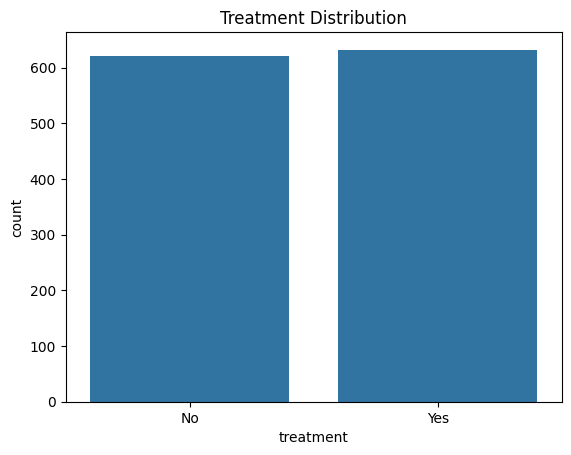

In [ ]:
sns.countplot(x="treatment", data=df)
plt.title("Treatment Distribution")
plt.xticks([0,1], ["No", "Yes"])
plt.show()



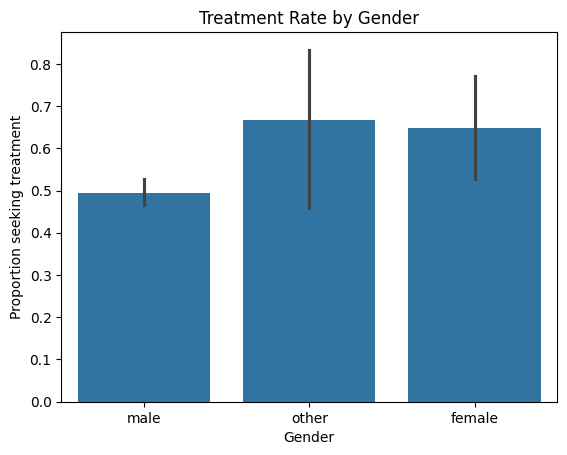

In [ ]:
raw = pd.read_csv(path + "/survey.csv")
raw = raw[raw["Age"].between(10,100)]
raw["Gender"] = raw["Gender"].apply(clean_gender)
raw["treatment"] = label.fit_transform(raw["treatment"])

sns.barplot(x="Gender", y="treatment", data=raw, estimator=np.mean)
plt.title("Treatment Rate by Gender")
plt.ylabel("Proportion seeking treatment")
plt.show()


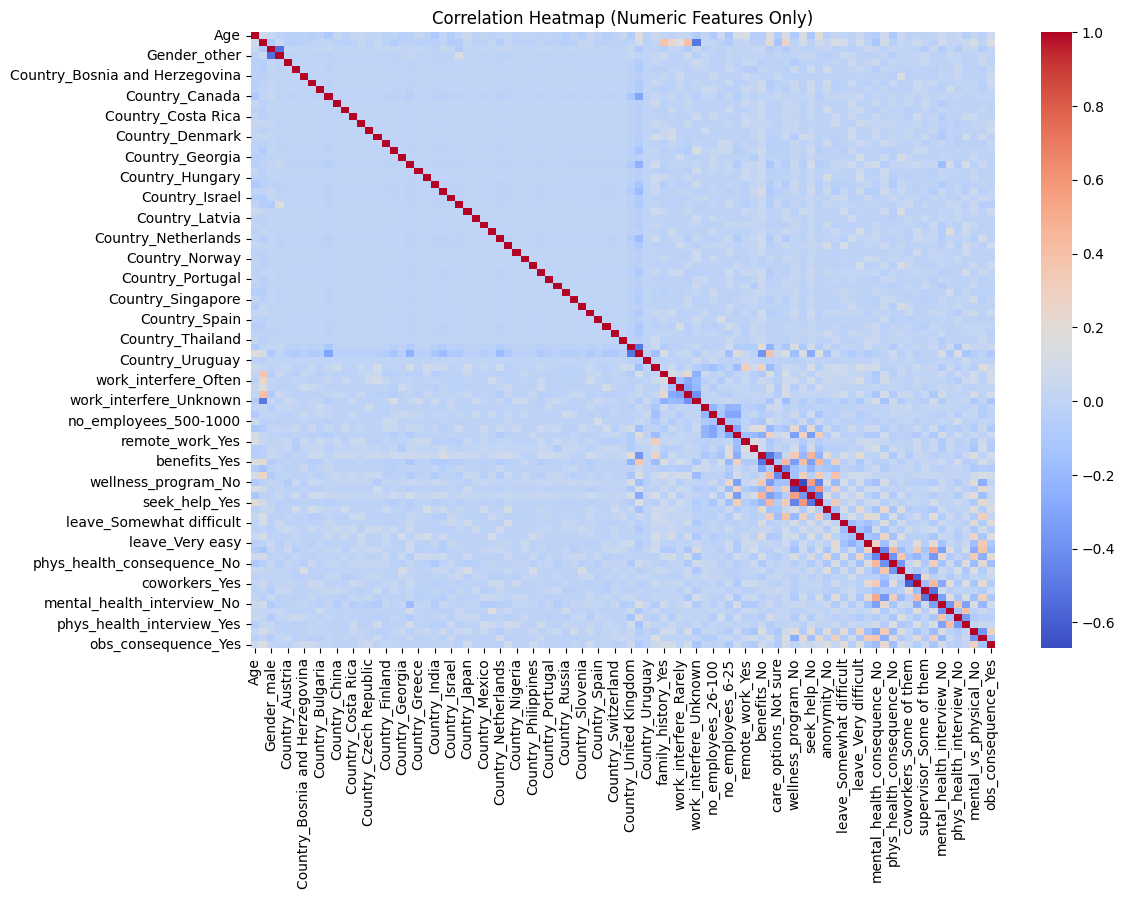

In [ ]:
numeric_df = df.select_dtypes(include=["int64","float64","bool"])

plt.figure(figsize=(12,8))
sns.heatmap(numeric_df.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


### EDA observations

- The dataset is quiet balanced between `treatment = Yes` and `No`.
- The probability of seeking treatment differs across gender groups.
- Workplace interference and benefits appear correlated with `treatment`.

These observations motivate using workplace and personal factors as predictors of treatment.


In [ ]:
X = df.drop("treatment", axis=1)
y = df["treatment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape


((876, 90), (376, 90))

In [ ]:
tree_entropy = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=4,
    random_state=42
)

tree_entropy.fit(X_train, y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

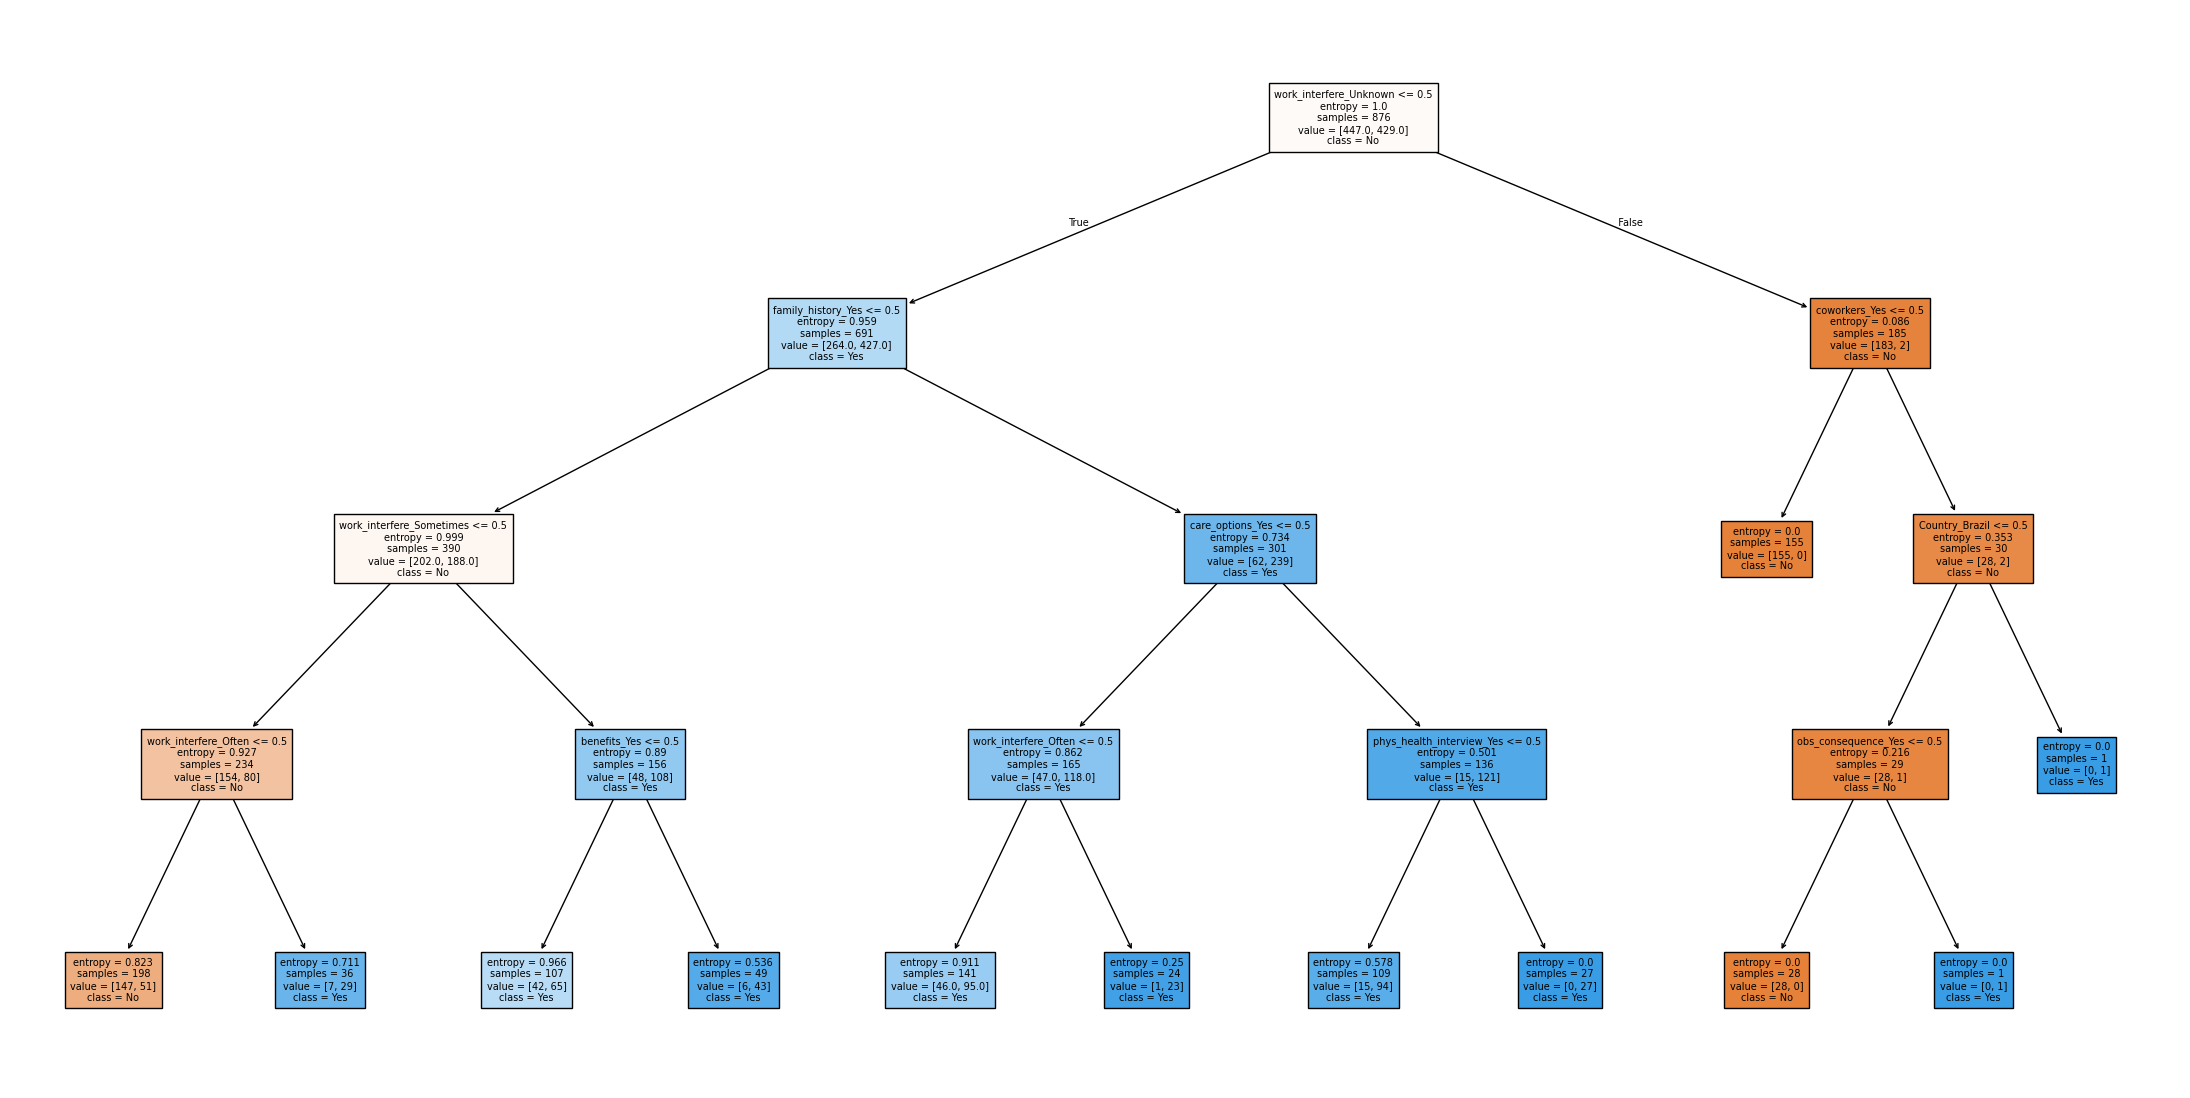

In [ ]:
plt.figure(figsize=(28, 14))
plot_tree(
    tree_entropy,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    filled=True,
    fontsize=7
)
plt.show()


The decision tree uses a series of tests of the form **feature ≤ threshold** to split the
feature space into rectangular regions. Each internal node chooses the split that minimizes the expected entropy of its children.

In [ ]:
y_pred_entropy = tree_entropy.predict(X_test)

print("Decision Tree (Entropy) – Accuracy:", accuracy_score(y_test, y_pred_entropy))
print("\nClassification Report:\n", classification_report(y_test, y_pred_entropy, target_names=["No","Yes"]))


Decision Tree (Entropy) – Accuracy: 0.8218085106382979

Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.73      0.79       173
         Yes       0.80      0.90      0.85       203

    accuracy                           0.82       376
   macro avg       0.83      0.81      0.82       376
weighted avg       0.83      0.82      0.82       376



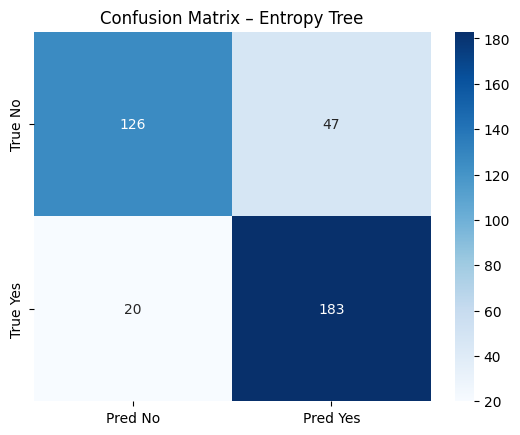

In [ ]:
cm_entropy = confusion_matrix(y_test, y_pred_entropy)

sns.heatmap(cm_entropy, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred No","Pred Yes"],
            yticklabels=["True No","True Yes"])
plt.title("Confusion Matrix – Entropy Tree")
plt.show()


### Evaluation Summary (Entropy)

The entropy-based decision tree achieved an overall **test accuracy of approximately 0.82**.
This indicates that the model correctly predicts treatment behavior for about 82% of
individuals in the test set.

Looking at class-wise performance:

- **Class "Yes" (seeking treatment)**  
  - Precision ≈ 0.80  
  - Recall ≈ 0.90  
  - The high recall indicates that the model correctly identifies most individuals who
    actually seek treatment. This is desirable in a mental-health context, where failing
    to detect someone who may need help (a false negative) is more costly than
    mistakenly predicting “Yes”.

- **Class "No" (not seeking treatment)**  
  - Precision ≈ 0.86  
  - Recall ≈ 0.73  
  - The lower recall for "No" shows that the model occasionally classifies "No" cases
    as "Yes".


Overall, the entropy-based decision tree provides reliable predictions and displays an
appropriate bias toward identifying individuals who seek treatment.



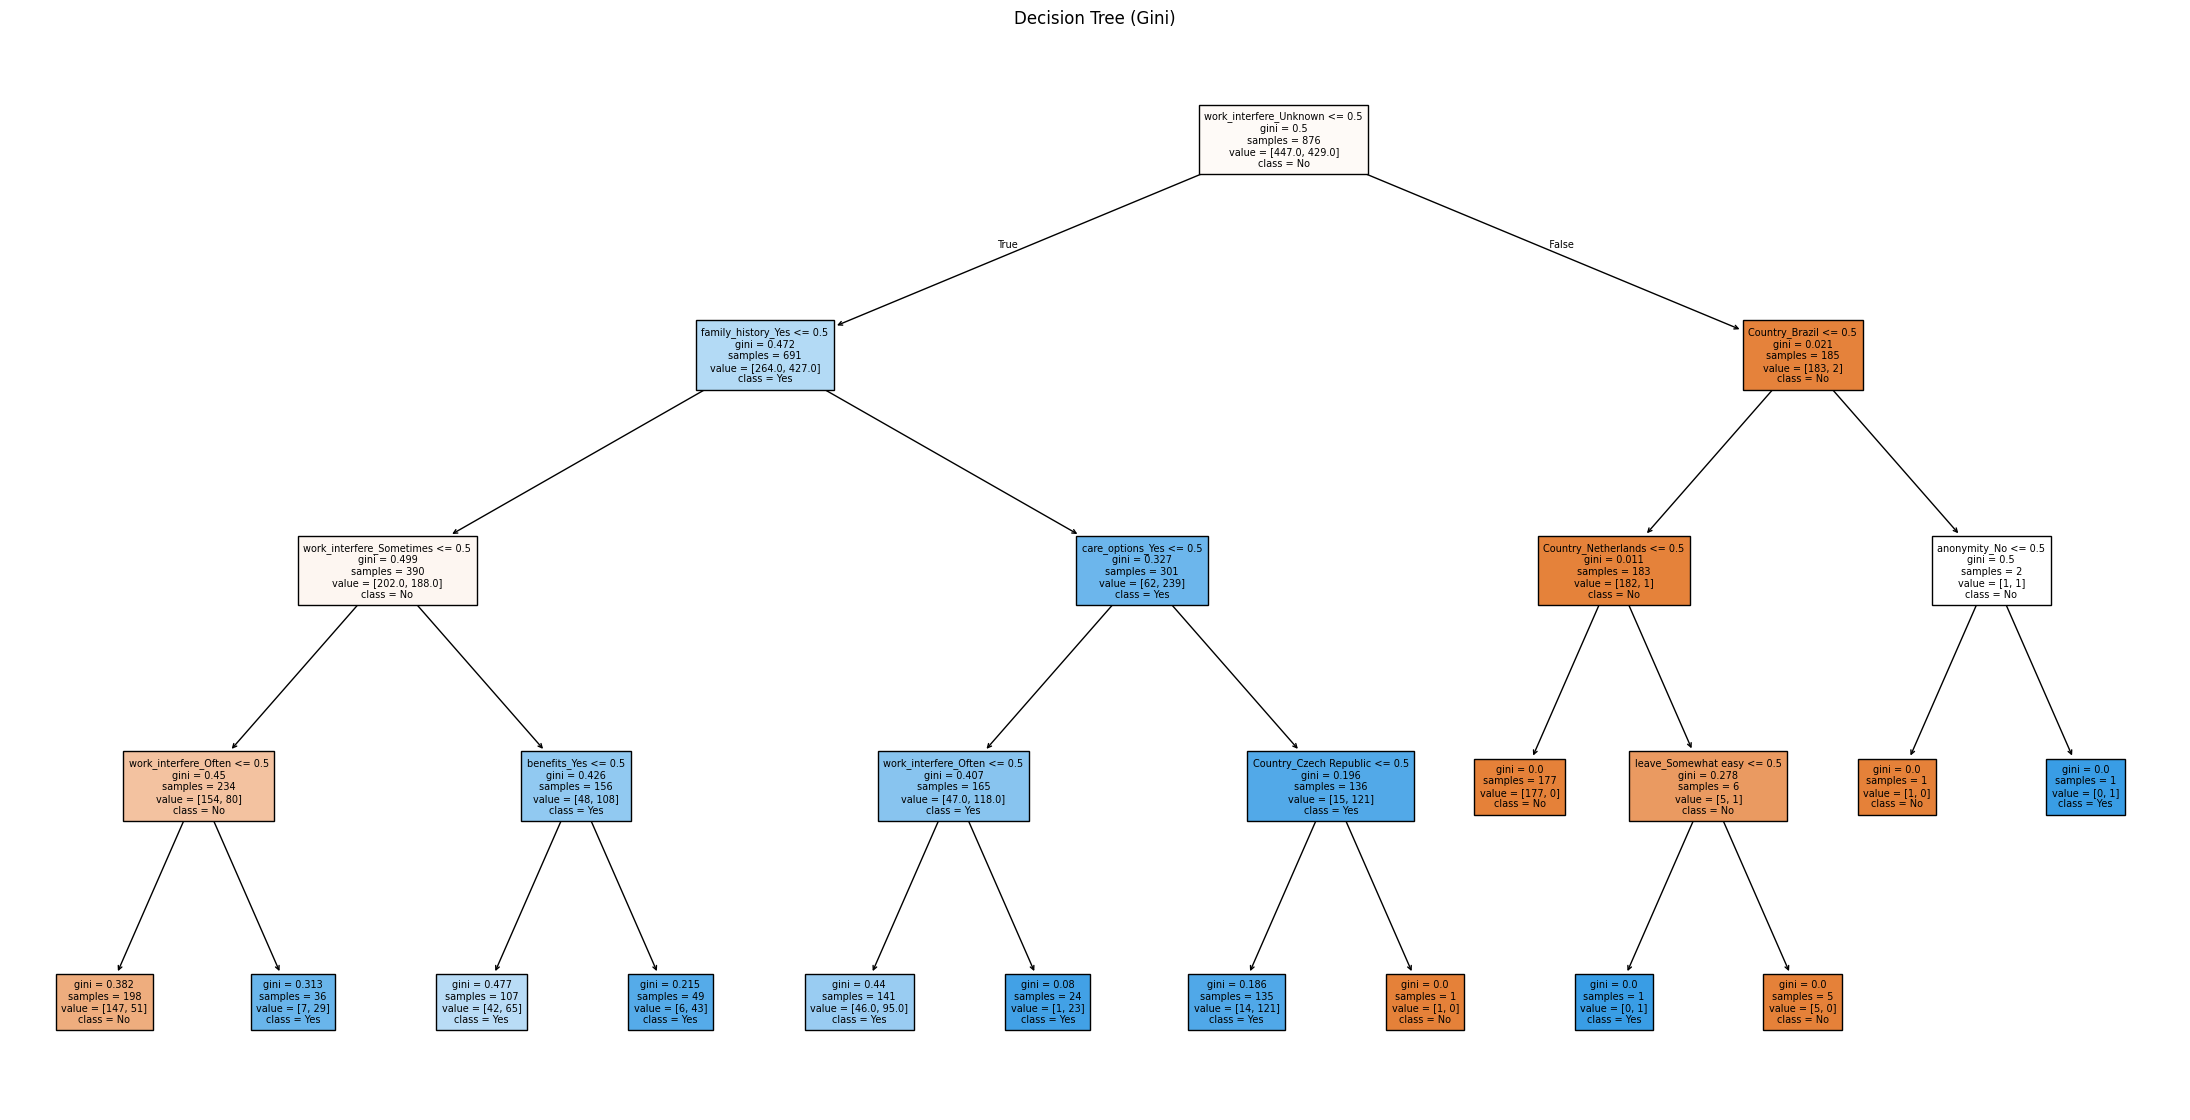

In [ ]:
tree_gini = DecisionTreeClassifier(
    criterion="gini",
    max_depth=4,
    random_state=42
)

tree_gini.fit(X_train, y_train)
y_pred_gini = tree_gini.predict(X_test)

plt.figure(figsize=(28, 14))
plot_tree(
    tree_gini,
    feature_names=X.columns,
    class_names=["No", "Yes"],
    filled=True,
    fontsize=7
)
plt.title("Decision Tree (Gini)")
plt.show()


In [ ]:

print("Decision Tree (Gini) – Accuracy:", accuracy_score(y_test, y_pred_gini))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gini, target_names=["No","Yes"]))


Decision Tree (Gini) – Accuracy: 0.8191489361702128

Classification Report:
               precision    recall  f1-score   support

          No       0.86      0.72      0.79       173
         Yes       0.79      0.90      0.84       203

    accuracy                           0.82       376
   macro avg       0.83      0.81      0.81       376
weighted avg       0.82      0.82      0.82       376



### Comparison: Entropy vs Gini

In our experiment, the entropy-based and Gini-based trees achieved similar
performance:

- Both models reached an accuracy of around **0.82**.
- Class-wise precision, recall, and F1-scores were also very close.
- Both trees showed a strong bias toward correctly identifying the "Yes" (treatment) class.

Although some threshold values and split orders differed little between the trees,
these differences did not affect their predictive performance.

This matches theoretical expectations:  
in practice, Gini and Entropy almost always yield similar results.


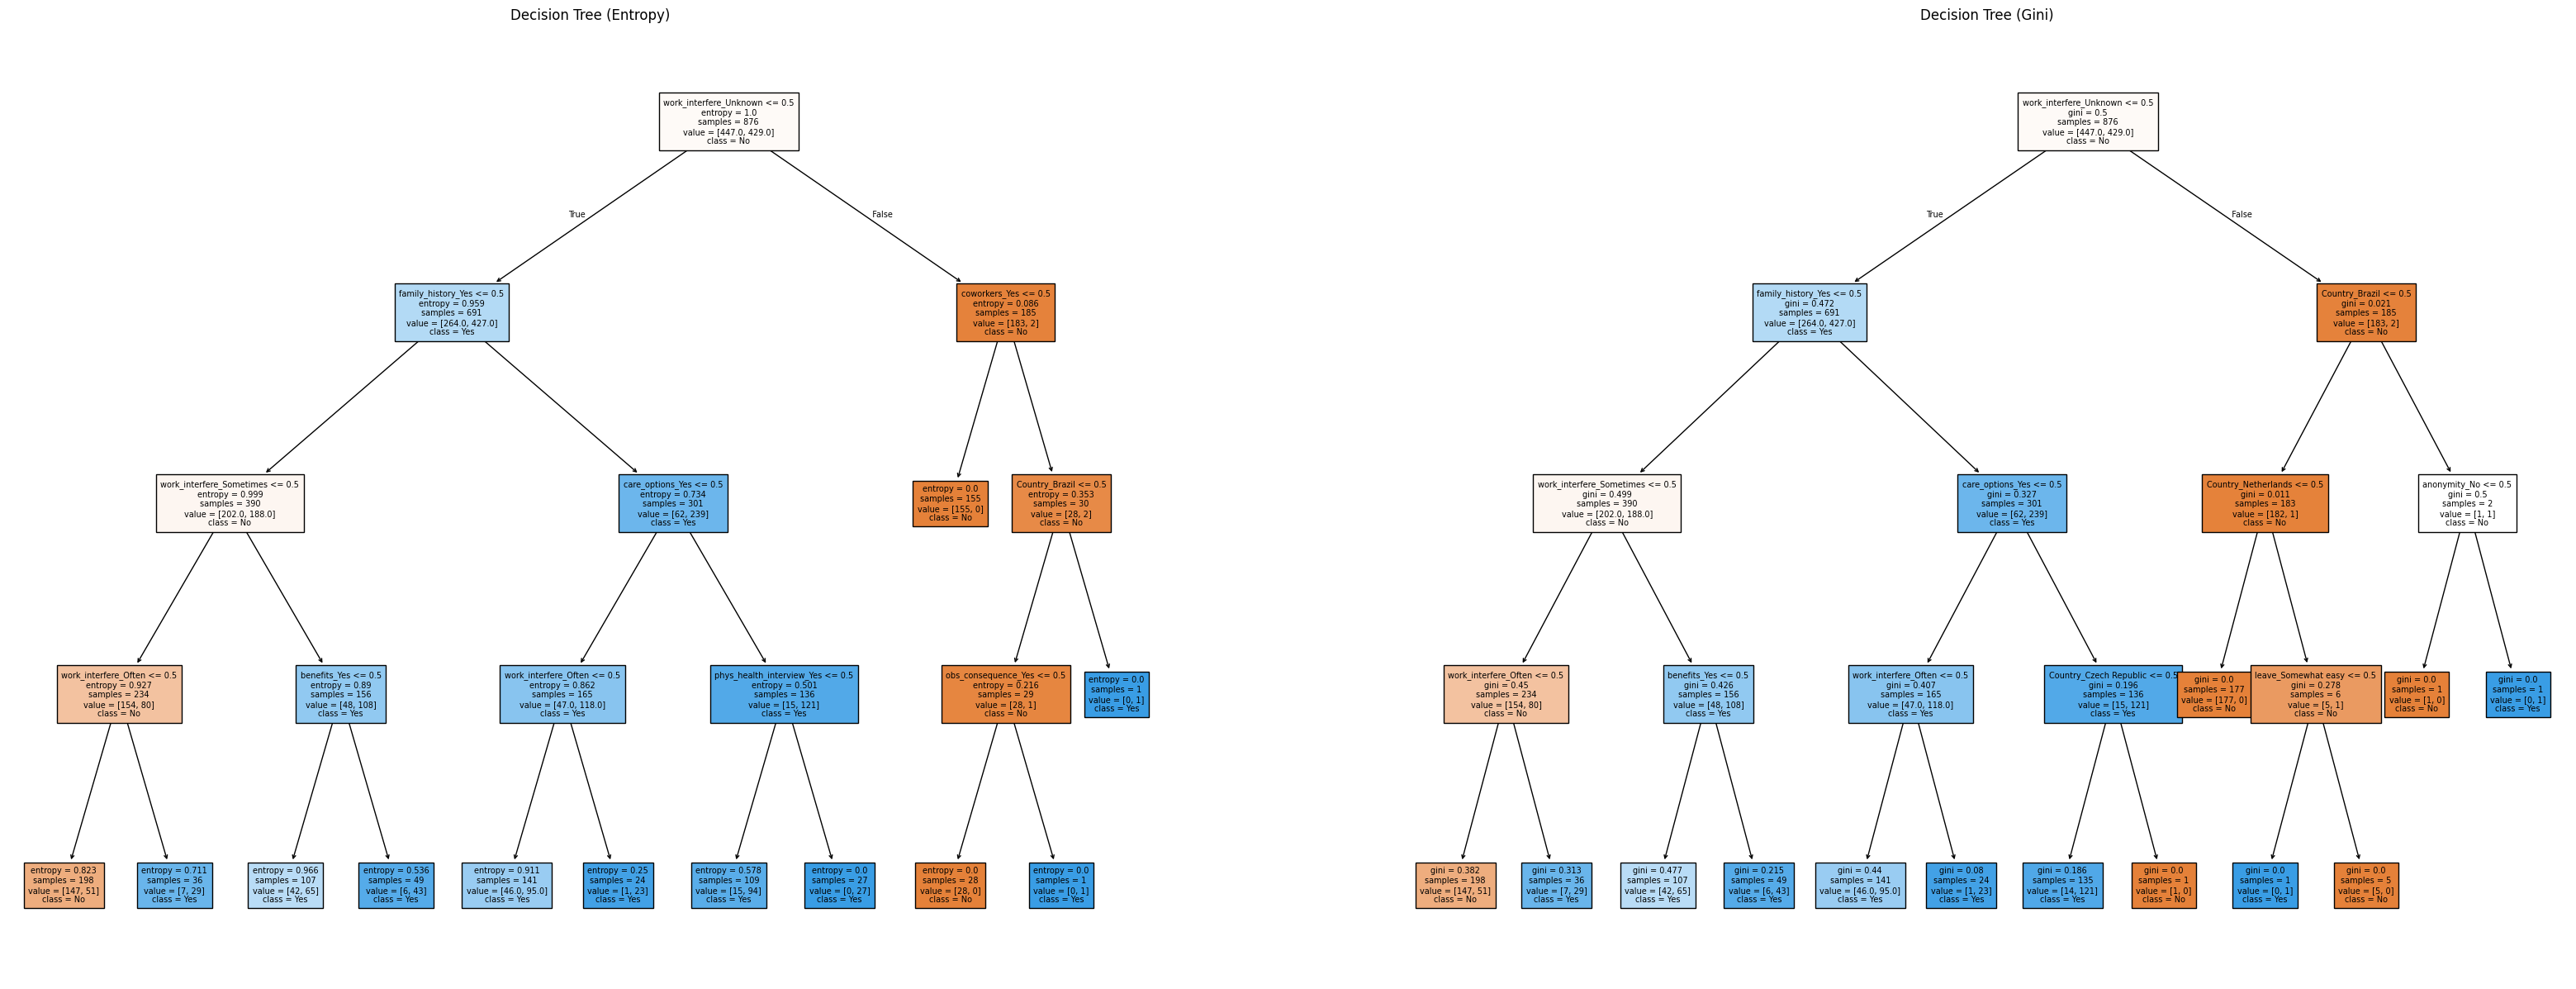

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(40, 15))

plot_tree(tree_entropy, feature_names=X.columns, class_names=["No","Yes"], filled=True, fontsize=7, ax=axes[0])
axes[0].set_title("Decision Tree (Entropy)")

plot_tree(tree_gini, feature_names=X.columns, class_names=["No","Yes"], filled=True, fontsize=7, ax=axes[1])
axes[1].set_title("Decision Tree (Gini)")

plt.show()


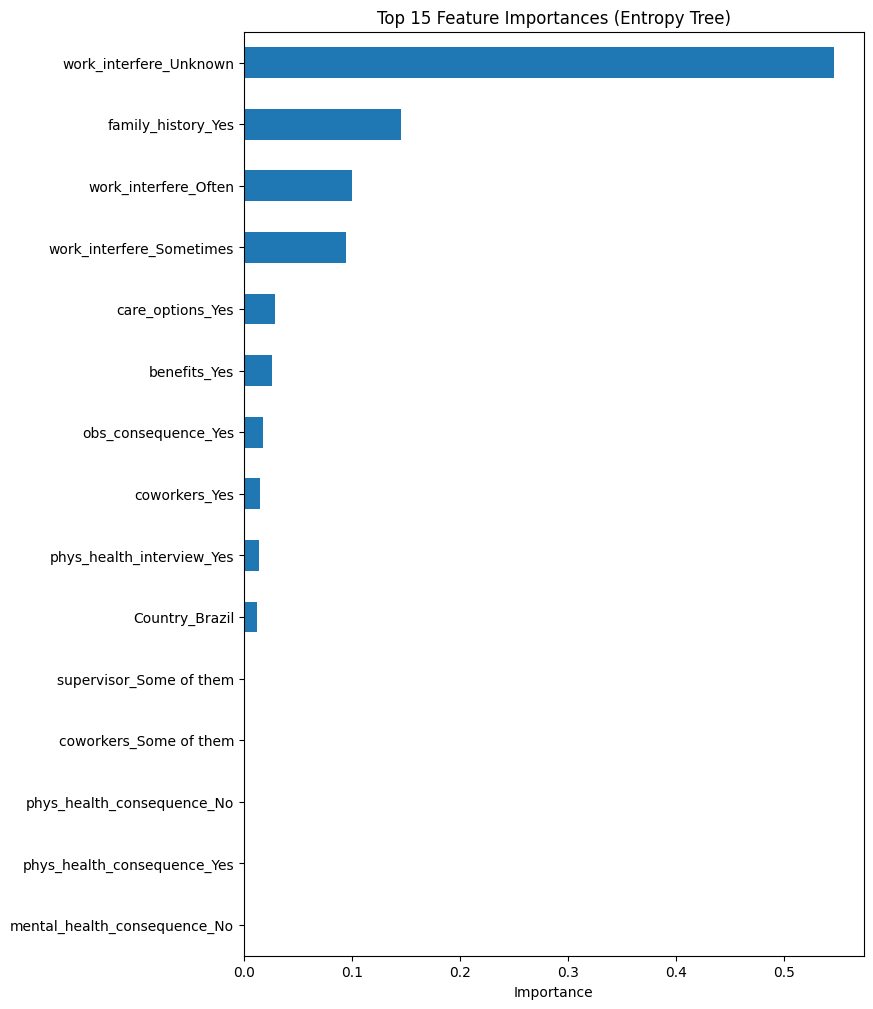

In [ ]:
importances = pd.Series(tree_entropy.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=True)

plt.figure(figsize=(8, 12))
importances.tail(15).plot(kind="barh")
plt.title("Top 15 Feature Importances (Entropy Tree)")
plt.xlabel("Importance")
plt.show()
